In [69]:
import torch
import torch.nn as nn

In [70]:
class ImageNN(torch.nn.Module):
    def __init__(self):
        super(ImageNN, self).__init__()
        self.neural_network_graph = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 500), # 28x28 = 784 pixels (Input layer)
            nn.ReLU(), # ReLU activation function
            nn.Linear(500, 350),
            nn.Dropout(0.5),  # Dropout with a dropout rate of 0.5
            nn.LayerNorm(350),
            nn.ReLU(),
            nn.Linear(350, 200),
            nn.ReLU(),
            nn.Linear(200, 10), # 10 classes (Output layer)
        )

    def forward(self, x):
        return self.neural_network_graph(x)

In [71]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses_, val_losses_, train_accuracies_, val_accuracies_):
    epochs_range = range(1, len(train_losses_) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses_, label='Training Loss')
    plt.plot(epochs_range, val_losses_, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies_, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies_, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [72]:
def train(dataloader, mod, loss_fn, optimizer):
    mod.train() # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the gradients to avoid accumulation
        outputs = mod(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    average_loss = running_loss / len(dataloader)
    train_acc = correct / total

    return average_loss, train_acc

def evaluate(dataloader, mod, loss_fn):
    mod.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_inputs, val_labels in dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = mod(val_inputs)
            validation_loss = loss_fn(val_outputs, val_labels)
            val_running_loss += validation_loss.item()

            _, predicted = torch.max(val_outputs, 1)
            correct += (predicted == val_labels).sum().item()
            total += val_labels.size(0)

    validation_loss = val_running_loss / len(dataloader)
    validation_accuracy = correct / total

    return validation_loss, validation_accuracy

## 1) Data Preparation

In [73]:
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Subtract 0.5 and divide by 0.5 -> map to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_dataset, val_dataset = train_test_split(
    train_dataset,
    test_size=0.2,
)

batch_size = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## 2) Model

In [74]:
model = ImageNN()
learning_rate = 0.01
cross_entropy_loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

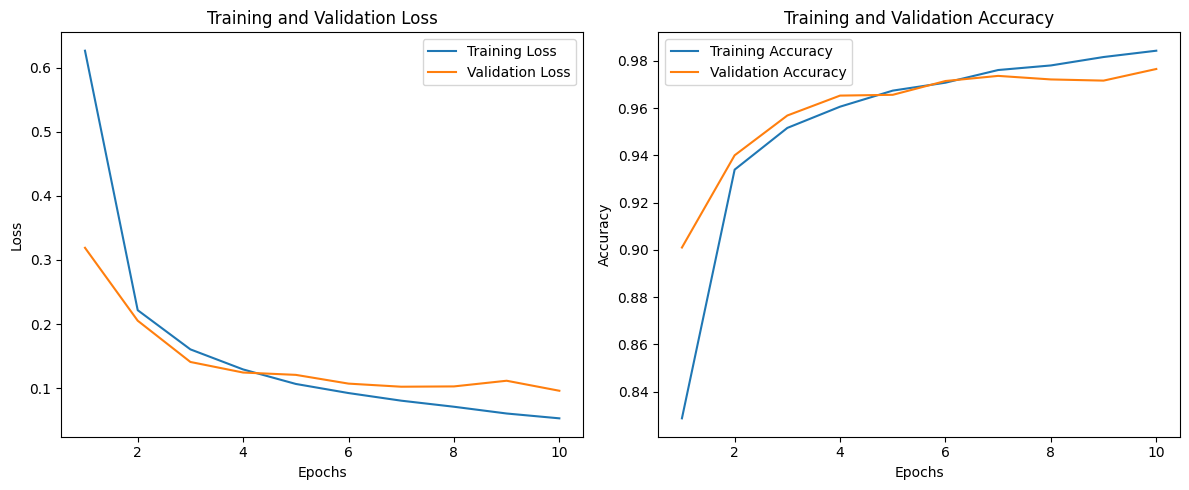

In [75]:
epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for t in range(epochs):
    train_loss, train_accuracy = train(train_dataloader, model, cross_entropy_loss, opt)
    val_loss, val_accuracy = evaluate(val_dataloader, model, cross_entropy_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## 3) Analysis

In [78]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [32, 64, 128, 256, 512]

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        model = ImageNN()
        opt = torch.optim.SGD(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        
        train(train_dataloader, model, loss_fn, opt)
        val_loss, val_accuracy = evaluate(val_dataloader, model, loss_fn)

        results.append({
            'learning_rate': lr,
            'batch_size': batch_size,
            'validation_loss': val_loss,
            'validation_accuracy': val_accuracy
        })

# Print or analyze the results
for i in range(len(results)):
    result = results[i]
    print(f"Epoch {i+1}:")
    print(f"Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}")
    print(f"Validation Loss: {result['validation_loss']}, Validation Accuracy: {result['validation_accuracy']*100}%")
    print("=" * 50)
    print("\n")

Epoch 1:
Learning Rate: 0.1, Batch Size: 32
Validation Loss: 0.27539739658000567, Validation Accuracy: 93.29166666666666%


Epoch 2:
Learning Rate: 0.1, Batch Size: 64
Validation Loss: 0.25193871824846914, Validation Accuracy: 93.34166666666667%


Epoch 3:
Learning Rate: 0.1, Batch Size: 128
Validation Loss: 0.2666352123633648, Validation Accuracy: 93.86666666666666%


Epoch 4:
Learning Rate: 0.1, Batch Size: 256
Validation Loss: 0.23691216445776322, Validation Accuracy: 94.04166666666667%


Epoch 5:
Learning Rate: 0.1, Batch Size: 512
Validation Loss: 0.24150516599944483, Validation Accuracy: 93.90833333333333%


Epoch 6:
Learning Rate: 0.01, Batch Size: 32
Validation Loss: 0.24356091569115718, Validation Accuracy: 92.70833333333334%


Epoch 7:
Learning Rate: 0.01, Batch Size: 64
Validation Loss: 0.24650824883580208, Validation Accuracy: 92.49166666666667%


Epoch 8:
Learning Rate: 0.01, Batch Size: 128
Validation Loss: 0.2245528945326805, Validation Accuracy: 93.175%


Epoch 9:
Learn